Importing the required libraries

In [1]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

torchtext.disable_torchtext_deprecation_warning()

from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

Image Captions

We have 4 captioins for each image.

In [2]:
img_cap = pd.read_csv("Dataset/flickr8k/captions.txt")
img_cap.sample(10)

,image,caption
36097,419116771_642800891d.jpg,a pack of dogs roughhousing by a car on a dirt...
25323,3325578605_afa7f662ec.jpg,A white crane flies over water .
39215,693450725_8ad72389e6.jpg,A closeup of a brown dog in front of a building .
27182,3399843227_3b9d2a8dbf.jpg,A man holding a drink poses with a woman .
37070,475778645_65b7343c47.jpg,A boy in a harness climbs a rock wall .
228,1057089366_ca83da0877.jpg,A little kid is jumping off a high dive at the...
4916,2094323311_27d58b1513.jpg,A dog snuggles with a man in sunglasses .
20421,3112821789_1f7c3bbb99.jpg,A man blows into a tube while standing in fron...
19448,3067971348_69af5bb309.jpg,Pedestrians and bikers crossing a busy street
29447,3485599424_94de8ede51.jpg,A dog chained in fronr of a house .


Loading the tokenizer and initializing the Counter

In [3]:
tokenizer = get_tokenizer("basic_english")

counter = Counter()

Building the vocabulary for captions

In [4]:
for line in img_cap["caption"].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

Adding the special tokens and setting the default index as UNK (unknown token)

In [5]:
unk_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

vocab.set_default_index(vocab["<unk>"])

Now, defining the dataset and the creating a get_item method that returns image with their captions tokens in integer form.

In [6]:
class FlickrDataset(Dataset):

    # Initializing the paramters for the dataset
    def __init__(self, root_dir, captions_file, vocab, transform = None):

        """
        root_dir: Path to the images folder
        captions_file: Path to the CSV file containing image names and captions
        vocab: Vocabulary object
        transform: Optional transform to be applied on the images
        """

        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        # Reading the captions file and storing the image names and captions in the DataFrame df
        df = pd.read_csv(captions_file)

        self.length = len(df)

        # Extracting the image names and captions from the DataFrame df
        self.captions = df["caption"]
        self.img_names = df["image"]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        # Getting caption and the image for the specified index
        caption = self.captions[idx]
        img_name = self.img_names[idx]

        # Loading the image and applying the transform if provided
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Tokenizing the caption and converting it to a list of indices in the vocabulary
        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        # Adding the start and end tokens to the caption vector and converting it to a PyTorch tensor
        caption_vec = []
        caption_vec += [vocab["<sos>"]]
        caption_vec += caption_text_to_index(caption)
        caption_vec += [vocab["<eos>"]]

        return img, torch.tensor(caption_vec)

In [7]:
class generate_batch_captioins:
    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        """
        Each batch: (image_tensor, caption_tensor)

        image_tensor:  [batch_size, num_channels, height, width]
        caption_tensor: [batch_size, num_words_in_caption]
        """
        # We will be seperating the images from the caption
        imgs = [item[0].unsqueeze() for item in batch]

        # Adding an extra dimension to the image
        imgs = torch.cat(imgs, dim = 0)

        # Separating the captions
        targets = [item[1] for item in batch]
        # Padding the captions with the pad token to make them of equal length
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)

        return imgs, targets

Helper function for Displaying the Image

In [8]:
def display_image(inp_img, title = "Image"):

    # Unnormalizing te images
    inp_img[0] = inp_img[0] * 0.229
    inp_img[1] = inp_img[1] * 0.224
    inp_img[2] = inp_img[2] * 0.225

    inp_img[0] += 0.485
    inp_img[1] += 0.456
    inp_img[2] += 0.406

    # By default the shape of an image using PyTorch is (n_c X n_h X n_w)
    # It has to be changed to (n_h X n_w X n_c)
    inp_img = inp_img.numpy().transpose((1, 2, 0))
    plt.imshow(inp_img)
    plt.title(title)
    plt.pause(0.1)
    plt.show()

Transformations for the Image.
- Resizing the Image
- Randomly Cropping the Image
- Conversion to Tensor
- Normalization

In [9]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Defining the dataset

In [10]:
root_dir = "Dataset/flickr8k/images"
captions_filepath = "Dataset/flickr8k/captions.txt"

In [11]:
flickr_dataset = FlickrDataset(
    root_dir = root_dir,
    captions_file = captions_filepath,
    vocab = vocab,
    transform = transforms
)

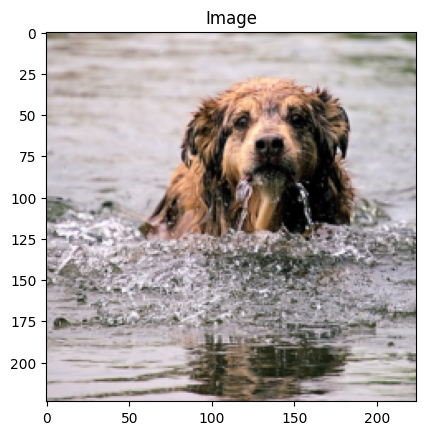

Token IDS: 
tensor([  2,   4, 226,  42,  29, 675, 221,  25, 337,  17,   3])
Caption: 
['<sos>', 'a', 'big', 'brown', 'dog', 'swims', 'towards', 'the', 'camera', '.', '<eos>']


In [12]:
# Getting the image and caption
img, ids = flickr_dataset[12345]

# Displating the image using the helper function
display_image(img)

# Printing the token IDs and the corresponding caption in the vocabulary
print("Token IDS: ")
print(ids)
print("Caption: ")
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

Defining the DataLoader

In [13]:
batch_size = 128
pad_idx = vocab["<pad>"]

data_loader = DataLoader(
    dataset = flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = generate_batch_captioins(pad_idx = pad_idx,
                                          batch_first = True)
)

Calling the ResNet model

In [14]:
resnet = models.resnet50()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Model is the seq2seq model. In the **encoder** pretrained resnet model is used to extract the features. **Decoder** is the implementation of the **Bahdanau Attention Decoder**.

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        for params in resnet.parameters():
            params.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):

        # With this the shape of the images will be [batch_size, 2048, 7, 7]
        features = self.resnet(images)

        batch, feature_maps, size_1, size_2 = features.size()

        # Changing the features to [batch_size, 7, 7, 2048]
        features = features.permute(0, 2, 3, 1)

        # Reshaping the features to [batch_size, 7 * 7, 2048]
        features = features.view(batch, size_1 * size_2, feature_maps)
        return features

Now, defining the Attention Mechanism

In [16]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, attn_size):
        super(Attention, self).__init__()

        self.attn_size = attn_size

        self.enc_U = nn.Linear(enc_hidden_size, attn_size)
        self.dec_W = nn.Linear(dec_hidden_size, attn_size)

        self.full_A = nn.Linear(attn_size, 1)

    def forward(self, features, decoder_hidden_state):

        # Making the decoder_hidden_state the same shape as of enc_U
        # [batch_size, dec_hidden_size] -> [batch_size, 1, dec_hidden_size]
        decoder_hidden_state = decoder_hidden_state.unsqueeze(1)

        # These are the features we got from EncoderCNN  [batch_size, 49, 2048]
        # [batch_size, 49, 2048] -> [batch_size, 49, attn_size]
        enc_attn = self.enc_U(features)

        # [batch_size, 1, dec_hidden_size] -> [batch_size, 1, attn_size]
        dec_attn = self.dec_W(decoder_hidden_state)

        # Combining both enc_attn and dec_attn
        # [batch_size, 49, attn_size]
        combined_state = torch.tanh(enc_attn + dec_attn)

        # attn_scores shape [batch_size, 49, 1]
        attn_scores = self.full_A(combined_state)

        # [batch_size, 49, 1] -> [batch_size, 49]
        attn_scores = attn_scores.squeeze(2) 

        # attn_weight shape [batch_size, 49]
        attn_weight = F.softmax(attn_scores, dim = 1)

        # context shape [batch_size, 49, 2048] -> [batch_size, 49] * [batch_size, 49, 2048]
        # Context has same dimensions as the encoding output i.e. the encoding_hidden_size
        context = torch.sum(attn_weight.unsqueeze(2) * features, dim = 1)

        return attn_weight, context